# データAugmentation有、モデル小の場合

# 音の分類していきます
### 追加したmodule
- librosa  (conda install librosa)

### フォルダ構成(create_dataset.ipynbを実行しておく)
./output_path --train--train.csv   
　　　　　　　　　　　　┗data--0.png, 1.png, ...   
　　　　　　　　┗test--train.csv  
　　　　　　　　　　　 ┗data--0.png, 1.png, ...



### 参考ページ
- https://qiita.com/cvusk/items/61cdbce80785eaf28349

# Softalk Datasetの読み込み

In [1]:
# softalk datasetの読み込み
# データセット読み込みインタフェース

# number⇒キャラクター変換
num2chara = ['reimu', 'man', 'robot']

import wave
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def softalk_load_data(data_path):
    chara_num = 3
    train_data_num = 55 * chara_num
    test_data_num = 12 * chara_num

    #返すデータ変数の生成
    x_train = []
    y_train = []
    n_train = []
    x_test = []
    y_test = []
    n_test = []

    #正解ファイル読み込み
    train_csv = pd.read_csv(filepath_or_buffer=data_path + 'train/train.csv', encoding="utf_8", sep=",")
    train_data = train_csv[['num', 'value']] 
    test_csv = pd.read_csv(filepath_or_buffer=data_path + 'test/test.csv', encoding="utf_8", sep=",")
    test_data = test_csv[['num', 'value']] 


    #データの格納(入力データ読み込みと同時に行う)
    for i in range(train_data_num):
       # input_data = cv2.imread(data_path + "train/img/" + str(i) + ".png", 1)
        wave_file = wave.open(data_path + "train/data/" + str(i) + ".wav","r") #Open
        input_data = wave_file.readframes(wave_file.getnframes()) #frameの読み込み
        input_data = np.frombuffer(input_data, dtype= "int16") #numpy.arrayに変換
        x_train.append(input_data)    
        y_train.append(train_data['value'][i])
        n_train.append(data_path + "train/data/" + str(i) + ".wav")

    for i in range(test_data_num):
       # input_data = cv2.imread(data_path + "test/img/" + str(i) + ".png", 1)
        wave_file = wave.open(data_path + "test/data/" + str(i) + ".wav","r") #Open
        input_data = wave_file.readframes(wave_file.getnframes()) #frameの読み込み
        input_data = np.frombuffer(input_data, dtype= "int16") #numpy.arrayに変換

        x_test.append(input_data)
        y_test.append(test_data['value'][i])
        n_test.append(data_path + "test/data/" + str(i) + ".wav")
        
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    n_train = np.array(n_train)
    n_test = np.array(n_test)

    return (x_train, y_train, n_train), (x_test, y_test, n_test)



x_train 165 y_train 165 x_test 36 y_test 36


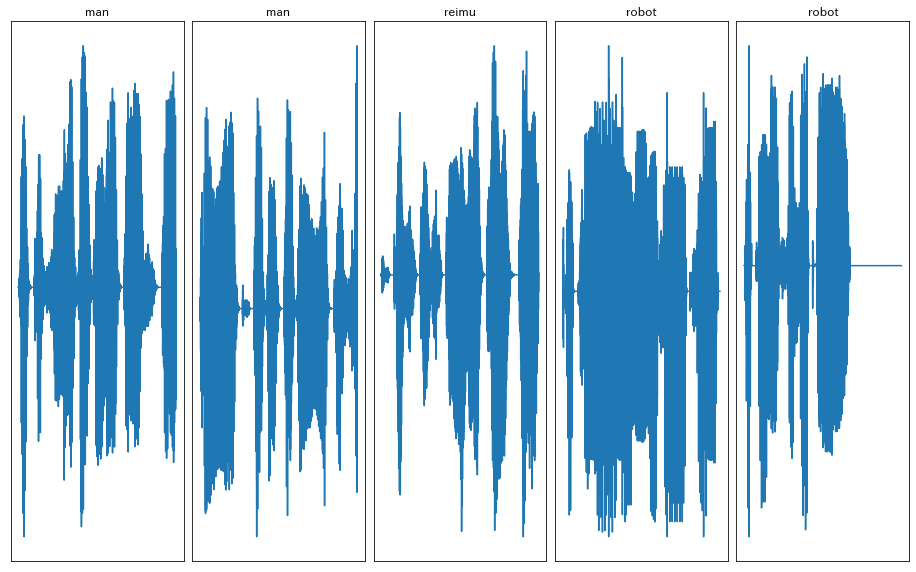

In [2]:
# データ読み込み
(x_train, y_train, n_train), (x_test, y_test, n_test) = softalk_load_data('./dataset/')
print('x_train', len(x_train), 'y_train', len(y_train),'x_test', len(x_test),'y_test', len(y_test))

# データ表示
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)

# 各MNIST画像の上に（タイトルとして）対応するラベルを表示
for i in range(5):
    ax = fig.add_subplot(1, 6, i + 1, xticks=[], yticks=[])
    ax.set_title(num2chara[y_train[i]])
    ax.plot(x_train[i])


In [3]:
# vscodeだと再生できない？
# choromeだと再生できる？
import IPython.display as ipd
ipd.Audio(x_train[0], rate=44100)

# 基本処理関数定義

173
wave size:(88200,)
melsp size:(64, 173)
samping rate:44100


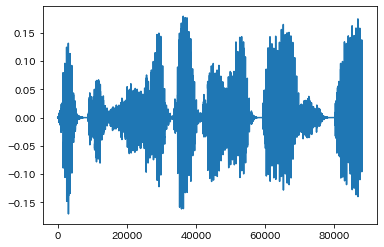

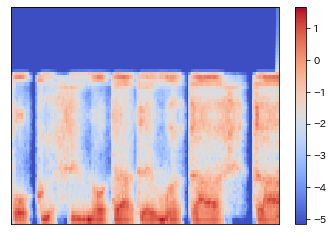

In [3]:
import os
import random
import numpy as np
import math
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt


# load a wave data
def load_wave_data(file_name):
    x, fs = librosa.load(file_name, sr=44100)
    return x,fs

# これが肝らしい　1次元から2次元データへ
# change wave data to mel-stft
def calculate_melsp(x, n_mel, n_fft, hop_length):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=n_mel)
    return melsp

# display wave in plots
def show_wave(x):
    plt.plot(x)
    plt.show()

# display wave in heatmap
def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, sr=fs)
    plt.colorbar()
    plt.show()


# example data
hop_length = 512
n_fft = 2048
n_mels = 64


x, fs = load_wave_data(n_train[0])
melsp = calculate_melsp(x, n_mels, n_fft, hop_length)
mels_t = math.ceil(x.shape[0] / hop_length)
print(mels_t)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x.shape, melsp.shape, fs))
show_wave(x)
show_melsp(melsp, fs)



# データAugmentation

In [4]:
# 参考ページの関数群
# データのAugmentation
# ホワイトノイズ付与　(一様分布はホワイトノイズ)
def add_white_noise(x, rate=0.002):
    return x + rate*np.random.randn(len(x))

# shift sound in timeframe
def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

# data augmentation: stretch sound
def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(x, rate)
    if len(x)>input_length:
        return x[:input_length]
    else:
        return np.pad(x, (0, max(0, input_length - len(x))), "constant")


# データ前処理：波形データをメルスペクトログラムに変換する

In [5]:
train_num = y_train.shape[0]
test_num = y_test.shape[0]
freq = n_mels
time = mels_t

In [6]:
aug_num = 4
u_train = np.zeros(freq * time * train_num * aug_num).reshape(train_num * aug_num, freq, time)
v_train = []
rates1 = np.random.randint(1,50,train_num)/10000
rates2 = np.random.choice(np.arange(2,6),train_num)
rates3 = np.random.choice(np.arange(80,120),train_num)/100

for j in range(aug_num):
    print(j)
    for i in range(train_num):
        _x, fs = load_wave_data(n_train[i])
        if j == 1:
            _x = add_white_noise(x=_x, rate=rates1[i])
        if j == 2:
            _x = shift_sound(x=_x, rate=rates2[i])
        if j == 3:
            _x = stretch_sound(x=_x, rate=rates3[i])
        _x = calculate_melsp(_x, n_mels, n_fft, hop_length)
        u_train[train_num * j + i] = _x
        v_train.append(y_train[i])

v_train = np.array(v_train)

u_test = np.zeros(freq * time * test_num).reshape(test_num, freq, time)
for i in range(test_num):
    _x, fs = load_wave_data(n_test[i])
    _x = calculate_melsp(_x, n_mels, n_fft, hop_length)
    u_test[i] = _x

0
1
2
3


# 学習始めていく

In [7]:
# Keras 前処理
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers import Conv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Add
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

# redefine target data into one hot vector
classes = 3
v_train = keras.utils.to_categorical(v_train, classes)
y_test = keras.utils.to_categorical(y_test, classes)

# 入力データのリサイズ
u_train = u_train.reshape(train_num * aug_num, freq, time, 1)
u_test = u_test.reshape(test_num, freq, time, 1)

print('u_train', u_train.shape, 'y_train', v_train.shape,'x_test', u_test.shape,'y_test', y_test.shape)


Using TensorFlow backend.
u_train (660, 64, 173, 1) y_train (660, 3) x_test (36, 64, 173, 1) y_test (36, 3)


In [8]:


def cba(inputs, filters, kernel_size, strides):
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

# define CNN
inputs = Input(shape=(u_train.shape[1:]))

x_1 = cba(inputs, filters=32, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=32, kernel_size=(8,1), strides=(2,1))

x_2 = cba(inputs, filters=32, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=32, kernel_size=(16,1), strides=(2,1))

x_3 = cba(inputs, filters=32, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=32, kernel_size=(32,1), strides=(2,1))

x = Add()([x_1, x_2, x_3])

x = cba(x, filters=128, kernel_size=(1,16), strides=(1,2))
x = cba(x, filters=128, kernel_size=(16,1), strides=(2,1))

x = GlobalAveragePooling2D()(x)
x = Dense(classes)(x)
x = Activation("softmax")(x)

model = Model(inputs, x)

# initiate Adam optimizer
opt = keras.optimizers.adam(lr=0.00001, decay=1e-6, amsgrad=True)

# Let's train the model using Adam with amsgrad
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()















__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 173, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 87, 32)   288         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 64, 87, 32)   544         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 64, 87, 32)   1056        input_1[0][0]                    
________________________________________________________________________________________________

In [9]:
# initiate Adam optimizer
opt = keras.optimizers.adam(lr=0.00001, decay=1e-6, amsgrad=True)

# Let's train the model using Adam with amsgrad
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


# directory for model checkpoints
model_dir = "./models2"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

# early stopping and model checkpoint# early  
es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
chkpt = os.path.join(model_dir, 'esc50_.{epoch:02d}_{val_loss:.4f}_{val_acc:.4f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')


# between class data generator
class MixupGenerator():
    def __init__(self, x_train, y_train, batch_size=16, alpha=0.2, shuffle=True):
        self.x_train = x_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(x_train)

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                x, y = self.__data_generation(batch_ids)

                yield x, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.x_train.shape
        _, class_num = self.y_train.shape
        x1 = self.x_train[batch_ids[:self.batch_size]]
        x2 = self.x_train[batch_ids[self.batch_size:]]
        y1 = self.y_train[batch_ids[:self.batch_size]]
        y2 = self.y_train[batch_ids[self.batch_size:]]
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        x_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        x = x1 * x_l + x2 * (1 - x_l)
        y = y1 * y_l + y2 * (1 - y_l)

        return x, y

# train model
batch_size = 16
epochs = 1000

training_generator = MixupGenerator(u_train, v_train)()
model.fit_generator(generator=training_generator,
                    steps_per_epoch=u_train.shape[0] // batch_size,
                    validation_data=(u_test, y_test),
                    epochs=epochs, 
                    verbose=1,
                    shuffle=True,
                    callbacks=[es_cb, cp_cb])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1000
41/41 [==============================] - 49s 1s/step - loss: 1.0610 - acc: 0.4146 - val_loss: 0.9722 - val_acc: 0.3333

Epoch 00001: val_loss improved from inf to 0.97218, saving model to ./models2\esc50_.01_0.9722_0.3333.hdf5
Epoch 2/1000
41/41 [==============================] - 46s 1s/step - loss: 0.9258 - acc: 0.5991 - val_loss: 0.9910 - val_acc: 0.3333

Epoch 00002: val_loss did not improve from 0.97218
Epoch 3/1000
41/41 [==============================] - 52s 1s/step - loss: 0.8311 - acc: 0.6951 - val_loss: 0.9239 - val_acc: 0.3333

Epoch 00003: val_loss improved from 0.97218 to 0.92392, saving model to ./models2\esc50_.03_0.9239_0.3333.hdf5
Epoch 4/1000
41/41 [==============================] - 50s 1s/step - loss: 0.7300 - acc: 0.7668 - val_loss: 0.9295 - val_acc: 0.3333

Epoch 00004: val_loss did not improve from 0.92392
Epoch 5/1000
41/41 [==============================] 

In [10]:
model_name = './models2/esc50_.68_0.0208_1.0000.hdf5'
model = load_model(model_name)

evaluation = model.evaluate(u_test, y_test)
print(evaluation)

36/36 [==============================] - 1s 37ms/step
[0.020808358469771013, 1.0]
